In [ ]:
##Ballistics Computer – Taking Into account the Centrifugal, and Corriolis Forces, drag forces (subsonic, and transonic), and wind
#By Felix W.

#Table of Contents (By Cell)

#1 – Imports
#2 – Basic Functions
#3 – Wind and Drag Curve Information
#4 – Firing Simulation Functions
#5 – Targeting Solution System (This is the coolest Part)
#6 – Basic Setting Information used for Basic Firing Simulator
#7 – Basic Firing Simulator

In [1]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import scipy as sci
import scipy.optimize as opti
from scipy.interpolate import interp1d

In [2]:
#General Functions needed to run 

def conv_sphtocart(A):      #Converts spherical coordinates to cartesian coordinates
    R = A[0]
    phi = A[1]
    theta = A[2]
    z = R*np.cos(phi)
    x = R*np.cos(theta)*np.sin(phi)
    y = R*np.sin(theta)*np.sin(phi)
    B = np.array((x,y,z))
    return B

def conv_carttosph(A):        #Converts cartesian coordinates to spherical
    x = A[0]
    y = A[1]
    z = A[2]
    R = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arccos(z/R)
    theta = np.arctan2(y,x)
    B = np.array((R,phi,theta))
    return B

def fire_M_calc(phi_att,ang):   #Calculates the cartesian initial unit velocity of our projectile
    
    fire_M = conv_sphtocart(np.array((1,phi_att,ang)))
    fire_M = np.matmul(np.array(((np.cos(-np.pi/2+lat),0,np.sin(-np.pi/2+lat)),(0,1,0),(-np.sin(-np.pi/2+lat),0,np.cos(-np.pi/2+lat)))),fire_M)
    fire_M = np.matmul(np.array(((np.cos(-long-np.pi),-np.sin(-long-np.pi),0),(np.sin(-long-np.pi),np.cos(-long-np.pi),0),(0,0,1))),fire_M)
    
    return fire_M

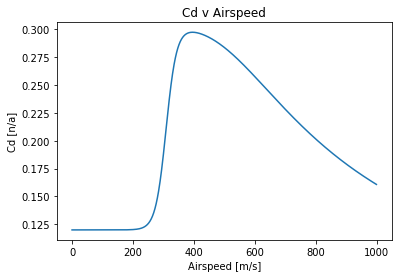

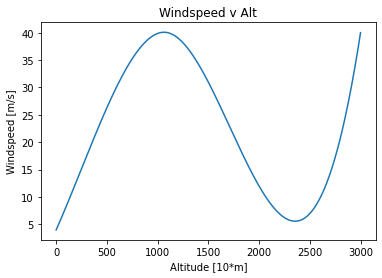

In [30]:
#Review Drag Coeffecient Curve

def dragcoef(m_t,v_t,k,alt):
    return ((1+np.exp((m_t-0.9)/0.05))**(-1)*(k)+(1+np.exp(-(m_t-0.9)/0.05))**(-1)*0.25*1.5/(((m_t**2-1)**2+1.5**4)**(1/4)))*atm_density*np.exp(-alt/7600)

k = 0.1 #Cd in Subsonic Regime
atm_density = 1.2 #At current elevation (kg/m^3)

alt = 0
mach = 343 #Speed of sound at alt=0
v_t = np.linspace(0,1000,1000) #Range of Velocity
m_t = v_t/mach
drag = dragcoef(m_t,v_t,k,alt)

plt.figure()
plt.title("Cd v Airspeed")
plt.xlabel("Airspeed [m/s]")
plt.ylabel("Cd [n/a]")
plt.plot(drag)
plt.show()

#Wind Information – (Approximated using a quadratic spline with ~0 m/s at alt = ~20km)

v_ground = 4 #in m/s
v_max = 40 #in m/s 
alt_max = 11000 #in m
v_ang =  360-90 #in degrees counter-clockwise from North

lat = 0 #Just scrap values used to initialize the functions
long = 0 #^

windspeedfunc = interp1d((-1000,0,alt_max,20000,30000),(0,v_ground,v_max,3*v_ground,v_max),kind='cubic')

def wind(v_ground,v_max,alt_max,v_ang,alti):
    
    windspeed = windspeedfunc(alti)
    
    r_wind = fire_M_calc(np.pi/2,v_ang/180*np.pi)
    
    return windspeed, r_wind

alt = np.linspace(0,30000,3000)
windy, r_wind = wind(v_ground,v_max,alt_max,v_ang,alt)
plt.figure()
plt.title("Windspeed v Alt")
plt.ylabel("Windspeed [m/s]")
plt.xlabel("Altitude [10*m]")
plt.plot(windy)
plt.show()

In [4]:
#Firing Simulation Functions

def fire_sim(fire_M, r, v_muz):              #General function that returns path of a flying projectile using step-wise integration
    
    step = 0.1
    r_ = r
    mach = 343

    #Initial Step
    v = v_muz*(fire_M)
    v_straight = v_muz*(fire_M)
    r = v*step+conv_sphtocart(r_)
    r_straight = v*step+conv_sphtocart(r_)

    r_record = [conv_carttosph(r)]
    r_record_straight = [conv_carttosph(r)]
    diff_record = [0]

    finished = False

    while not finished:
        alt = np.sqrt(r[0]**2+r[1]**2+r[2]**2)-R
        v_t = np.sqrt(v[0]**2+v[1]**2+v[2]**2)
        m_t = v_t/mach
        alt_straight = np.sqrt(r_straight[0]**2+r_straight[1]**2+r_straight[2]**2)-R
        v_t_straight = np.sqrt(v_straight[0]**2+v_straight[1]**2+v_straight[2]**2)
        m_t_straight = v_t_straight/mach
    
        windspeed, wind_v = wind(v_ground,v_max,alt_max,v_ang,alt)
        v_wind = v-1*(windspeed*wind_v)
        v_t_wind = np.sqrt(v_wind[0]**2+v_wind[1]**2+v_wind[2]**2)
    
        a_g = -r/(alt+R)*9.81
        a_fug = -np.cross(w_M,np.cross(w_M,r))
        a_cor = -2*np.cross(w_M,v)
        a_drag = -dragcoef(m_t,v_t_wind,k,alt)*v_wind*v_t_wind/m*A_r
        a_tot = a_g + a_fug + a_cor + a_drag
    
        windspeed, wind_v = wind(v_ground,v_max,alt_max,v_ang,alt_straight)
        v_wind_straight = v_straight-windspeed*wind_v
        v_t_wind_straight = np.sqrt(v_wind_straight[0]**2+v_wind_straight[1]**2+v_wind_straight[2]**2)
    
        a_g = -r_straight/(alt_straight+R)*9.81
        a_drag = -dragcoef(m_t_straight,v_t_wind_straight,k,alt_straight)*v_wind_straight*v_t_wind_straight/m*A_r
        a_straight = a_g + a_drag
    
        v = v+a_tot*step
        v_straight = v_straight + a_straight*step
    
        r = v*step+r
        r_straight = v_straight*step+r_straight
    
        r_diff = r-r_straight
        r_diff = np.sqrt(r_diff[0]**2+r_diff[1]**2+r_diff[2]**2)
        diff_record = np.append(diff_record,r_diff)
    
        r_sph = [conv_carttosph(r)]
        r_sph_straight = [conv_carttosph(r_straight)]
    
        r_record = np.append(r_record,r_sph,axis=0)
        r_record_straight = np.append(r_record_straight,r_sph_straight,axis=0)
    
        finished = (R>(np.sqrt(r[0]**2+r[1]**2+r[2]**2)))

    return r_record, r_record_straight, diff_record

def fire_jacobian(phi_att, ang, r, delt, v_muz):  ##Might need some fixing – Currently not in use
    
    att_delt = [[0,0],[0,0]]
    ang_delt = [[0,0],[0,0]]
    I = [-1,1]
    
    for i in [0,1]:
    
        phi_att_ = phi_att - I[i]*delt/180*np.pi
        ang_ = ang
        
        fire_M = conv_sphtocart(np.array((1,phi_att_,ang_)))
        fire_M = np.matmul(np.array(((np.cos(-np.pi/2+lat),0,np.sin(-np.pi/2+lat)),(0,1,0),(-np.sin(-np.pi/2+lat),0,np.cos(-np.pi/2+lat)))),fire_M)
        fire_M = np.matmul(np.array(((np.cos(-long-np.pi),-np.sin(-long-np.pi),0),(np.sin(-long-np.pi),np.cos(-long-np.pi),0),(0,0,1))),fire_M)
    
        r_record, trash1, trash2 = fire_sim(fire_M, r, v_muz)
        att_delt[i] = r_record[-1,1:]
        
        #plt.plot((r_record[:,2]-r_record[0,2])*R,R*(-r_record[:,1]+r_record[0,1]))
        
    #plt.show()
        
    for i in [0,1]:
    
        phi_att_ = phi_att
        ang_ = ang+I[i]*delt/180*np.pi
        
        fire_M = conv_sphtocart(np.array((1,phi_att_,ang_)))
        fire_M = np.matmul(np.array(((np.cos(-np.pi/2+lat),0,np.sin(-np.pi/2+lat)),(0,1,0),(-np.sin(-np.pi/2+lat),0,np.cos(-np.pi/2+lat)))),fire_M)
        fire_M = np.matmul(np.array(((np.cos(-long-np.pi),-np.sin(-long-np.pi),0),(np.sin(-long-np.pi),np.cos(-long-np.pi),0),(0,0,1))),fire_M)
    
        r_record, trash1, trash2 = fire_sim(fire_M, r, v_muz)
        
        #plt.plot((r_record[:,2]-r_record[0,2])*R,R*(-r_record[:,1]+r_record[0,1]))
        
        ang_delt[i] = r_record[-1,1:]
     
    #plt.show()
    delt_ang = (ang_delt[1]-ang_delt[0])*R/2
    delt_att = (att_delt[1]-att_delt[0])*R/2
    
    return np.matrix((delt_ang,delt_att)).T #This returns a jacobian matrix for a delta in ang & att (in degrees) to a delta in x-y final position (in m)

def miss_target(A,r,r_t,v_muz):      #Gives us a scalar measure of how much we miss a target – used for minimization algorithm

    phi_att = A[0]
    ang = A[1]
    
    r = B[0]
    r_t = B[1] #in spherical coords
    v_muz = B[2]
    
    fire_M = conv_sphtocart(np.array((1,phi_att,ang)))
    fire_M = np.matmul(np.array(((np.cos(-np.pi/2+lat),0,np.sin(-np.pi/2+lat)),(0,1,0),(-np.sin(-np.pi/2+lat),0,np.cos(-np.pi/2+lat)))),fire_M)
    fire_M = np.matmul(np.array(((np.cos(-long-np.pi),-np.sin(-long-np.pi),0),(np.sin(-long-np.pi),np.cos(-long-np.pi),0),(0,0,1))),fire_M)
    
    r_record, trash1, trash2 = fire_sim(fire_M, r, v_muz)
    r_diff = (r_record[-1,:]-r_t)*R
    R_diff = np.sqrt(r_diff[1]**2+r_diff[2]**2)
    return R_diff

Muzzle Velocity: 800 m/s
Attitude: 70.97068832900787 Angle: 344.84504264125565 | Dist to target: 0.21634577908870947m
Adjustment made for Pseudoforces: ~141.0m | Time to target: 112.7s
 
Muzzle Velocity: 650 m/s
Attitude: 57.84593439317257 Angle: 343.5279909385903 | Dist to target: 0.3438721190658235m
Adjustment made for Pseudoforces: ~89.0m | Time to target: 84.0s
 
Muzzle Velocity: 700 m/s
Attitude: 63.890776419874726 Angle: 344.0485336957652 | Dist to target: 0.18195475104274825m
Adjustment made for Pseudoforces: ~106.0m | Time to target: 94.9s
 
Muzzle Velocity: 750 m/s
Attitude: 67.8841582015956 Angle: 344.4850390927414 | Dist to target: 0.09440492690286206m
Adjustment made for Pseudoforces: ~122.0m | Time to target: 104.0s
 


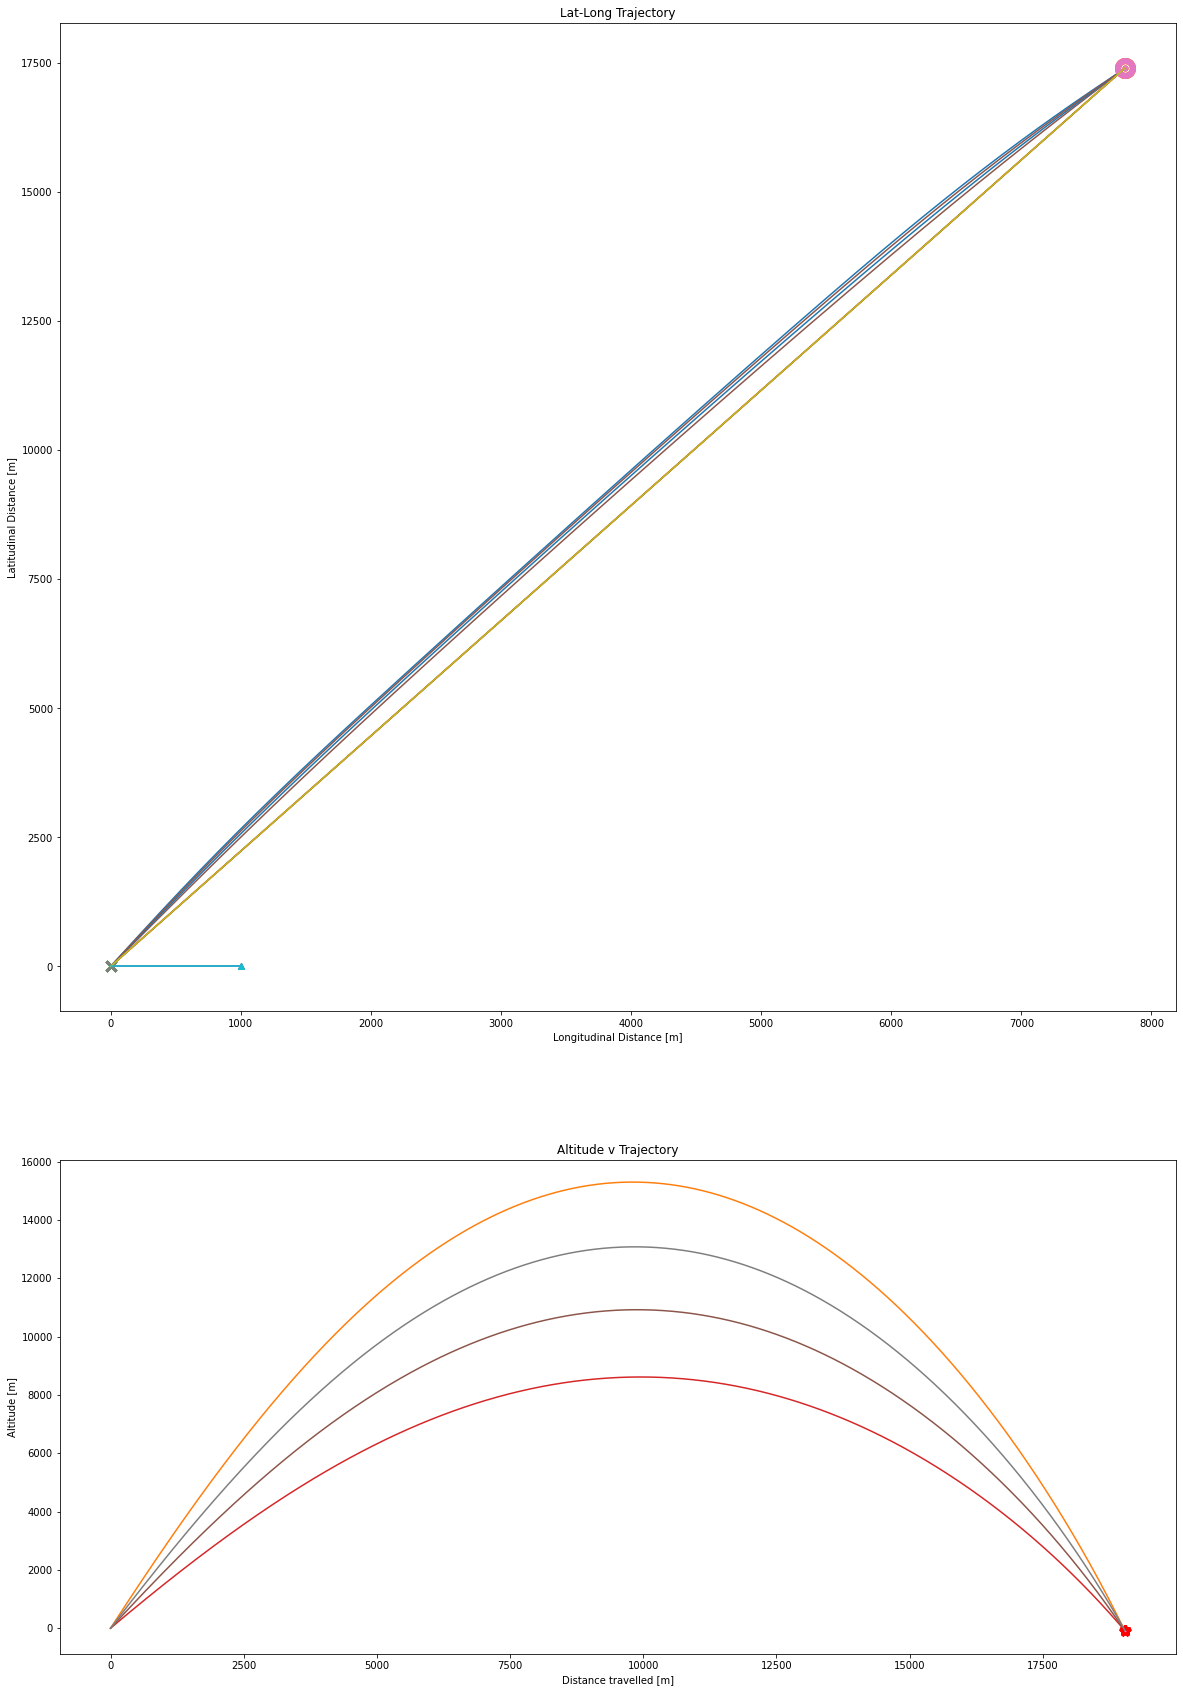

In [31]:
#Targetting Solution System – Gives two possible firing solutions for a target and it's accuracy

#Our Gun - Center of Tappan Square: (41.292920, -82.218830)

(lat_g, long_g) = (41.292920,-82.14871135326379)         #Lat-Long of our Gun
(lat_t, long_t) = (41.44945409201502,-82.218830)         #Lat_long of our Target
R = 6371000+247                                         #Altitude from earth core (assuming circular earth)

#________________________________________________#

#Some Processing Steps – No inputs here

lat = lat_g #degrees
long = 0 #degrees

w = 1/86164.0905*2*np.pi #sidereal frequency of earth's rotation

#Target –  Lorain Steel Plant: (41.44945409201502, -82.14871135326379)
lat_t = lat_t/180*np.pi #+ 13000/R
long_t = (long_g-long_t)/180*np.pi #+ 13000/R

r_t = np.array((R,np.pi/2-lat_t,long_t))

#________________________________________________#

#Initial Firing Conditions 
m = 70  #kg
radius = 0.155/2 # in m
A_r = np.pi*radius**2 #Cross-section
k = 0.1 #General Drag Coefficient
v_muz = 750 #m/s – Muzzle Velocity
att = 20 #Attitude of Gun
ang = 360-45 #Orientation of Gun – counter_clockwise from North

#Convert to Proper Units & Firing Transforms
lat = lat/180*np.pi
long = long/180*np.pi
phi_att = (90-att)/180*np.pi
ang = ang/180*np.pi

r = np.array((R,np.pi/2-lat,long))
w_rel = np.array((w,-np.pi/2+lat,-long))
w_M = np.array((0,0,w))

#________________________________________________#

fig, axs = plt.subplots(2, figsize=(20,30), gridspec_kw={'height_ratios': [2, 1]})

#This generates different firing solutions for different muzzle velocities 
#Set first value to 70 for a high angle attack, or set to 20 for a low angle attack

for i in ((70,800),(70,650),(70,700),(70,750)):  
    
    step = 0.1
    phi_att = (90-i[0])/180*np.pi
    x0 = (phi_att,ang)
    B = (r,r_t,i[1])

    result = opti.minimize(miss_target, x0,(r,r_t,i[1]), method='Nelder-Mead', tol=0.1) #Minimization Algorithm to find best fit firing parameters

    print("Muzzle Velocity: "+str(i[1])+" m/s")
    print("Attitude: "+str((90-result.x*180/np.pi)[0])+" Angle: "+str((result.x*180/np.pi)[1])+" | Dist to target: "+ str(miss_target((result.x),r,r_t,v_muz))+"m")

    fire_M = fire_M_calc(result.x[0],result.x[1])

    r_record, trash1, r_diff = fire_sim(fire_M, r, i[1])

    print("Adjustment made for Pseudoforces: ~" +str(np.ceil(r_diff[-1]))+"m | Time to target: " +str(len(r_record[:,0])*step)+"s")
    print(" ")

    axs[0].set_title("Lat-Long Trajectory")
    axs[0].plot((r_record[:,2]-r_record[0,2])*R,R*(-r_record[:,1]+r_record[0,1])) #This Shows us our solution path (Blue)
    axs[0].plot((r_t[2]-r[2])*R, -(r_t[1]-r[1])*R, marker='o', markeredgewidth=15) #Marks out target
    axs[0].plot(0, 0, marker='x', markersize=10, markeredgewidth=3) #Marks Us
    axs[0].set_xlabel("Longitudinal Distance [m]")
    axs[0].set_ylabel("Latitudinal Distance [m]")
    axs[0].plot((0,(r_t[2]-r[2])*R), (0,-(r_t[1]-r[1])*R)) #Marks a straight path (Red)
    axs[0].plot((-1000*np.sin(v_ang/180*np.pi),0),(1000*np.cos(v_ang/180*np.pi),0), marker='^', markevery=2) #Wind-marker


    r_dist = np.sqrt((r_record[:,1]-r_record[0,1])**2+(r_record[:,2]-r_record[0,2])**2)*R
    r_alt_path = (r_record[:,0]-r_record[0,0],r_dist)
    axs[1].set_title("Altitude v Trajectory")
    axs[1].set_xlabel("Distance travelled [m]")
    axs[1].set_ylabel("Altitude [m]")
    axs[1].plot(r_alt_path[1][-1], r_alt_path[0][-1], markeredgecolor='red',marker='*', markersize=10, markeredgewidth=3)
    axs[1].plot(r_alt_path[1],r_alt_path[0])

plt.show()

In [6]:
##Setting Location – Important for Basic Simulation

R = 6371000 #altitude from earth core (assuming circular earth)
lat = 45 #degrees
long = 0 #degrees

w = 1/86164.0905*2*np.pi #sidereal frequency of earth's rotation

#_________________________________________________#

#Setting Firing Info
m = 70  #kg
radius = 0.155/2 # in m
A_r = np.pi*radius**2 #Cross-section
k = 0.1 #General Drag Coefficient
v_muz = 1000 #m/s
att = 15 #Attitude of Gun
ang = 360-45 #Orientation of Gun – counter_clockwise from North

#_________________________________________________#

#Convert to Proper Units & Firing Transforms
lat = lat/180*np.pi
long = long/180*np.pi
phi_att = (90-att)/180*np.pi
ang = ang/180*np.pi

r = np.array((R,np.pi/2-lat,long))
w_rel = np.array((w,-np.pi/2+lat,-long))
w_M = np.array((0,0,w))

# This creates a unit vector in cartesian coordinates describing the initial projectile velocity
fire_M = conv_sphtocart(np.array((1,phi_att,ang)))
fire_M = np.matmul(np.array(((np.cos(-np.pi/2+lat),0,np.sin(-np.pi/2+lat)),(0,1,0),(-np.sin(-np.pi/2+lat),0,np.cos(-np.pi/2+lat)))),fire_M)
fire_M = np.matmul(np.array(((np.cos(-long-np.pi),-np.sin(-long-np.pi),0),(np.sin(-long-np.pi),np.cos(-long-np.pi),0),(0,0,1))),fire_M)

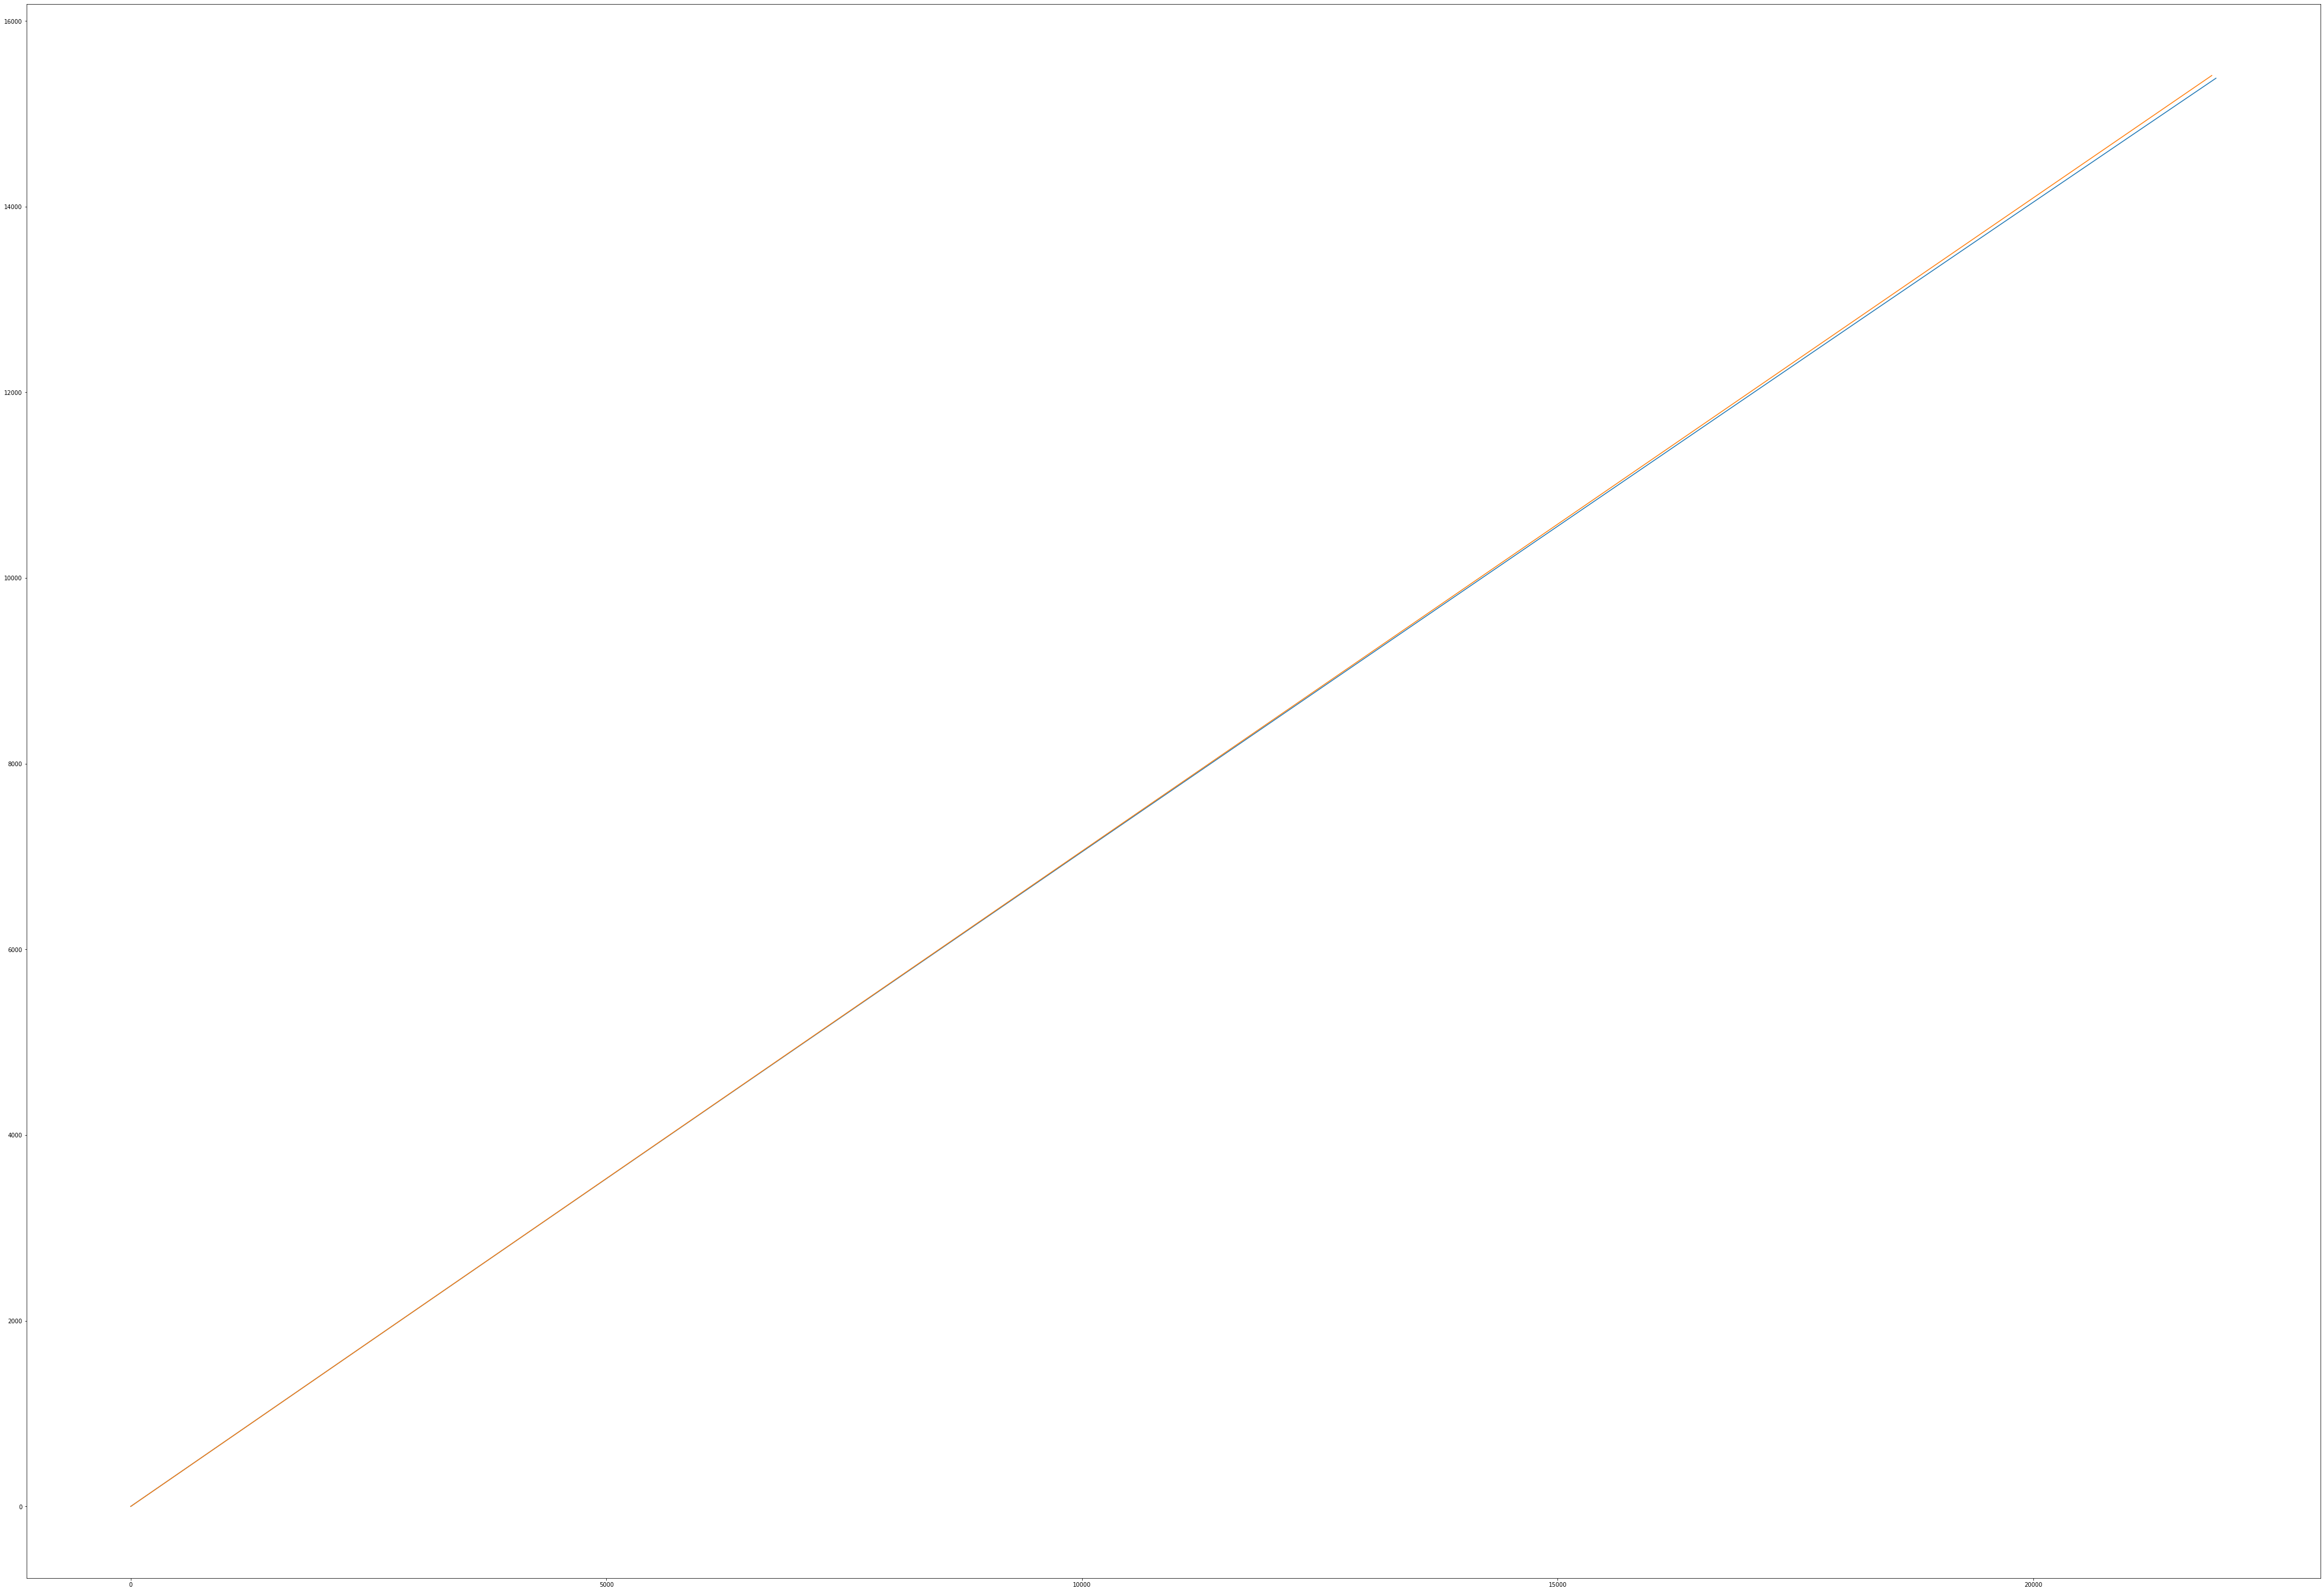

In [893]:
#Basic Firing Setup

r_record, r_record_straight, r_diff = fire_sim(fire_M, r, v_muz)

n = len(r_record)-1    
ratio = np.abs((r_record[n,2]-r_record[0,2])/(r_record[n,1]-r_record[0,1]))  

plt.figure(figsize=(int(np.floor(50*ratio)),50))
plt.plot((r_record[:,2]-r_record[0,2])*R,R*(-r_record[:,1]+r_record[0,1]))
plt.plot((r_record_straight[:,2]-r_record_straight[0,2])*R,R*(-r_record_straight[:,1]+r_record_straight[0,1]))
plt.show()